## CS 498: Assignment 1: Perspective Projection

Name: Priyam Mazumdar

NetID: priyamm2

### Homography

**Question 1 [1pt]:**

You are given a photo of the State Farm Center, UIUC's indoor arena that hosts our basketball teams. We marked and plotted the four corners of the court. A standard basketball court is 28.65 meters long and 15.24 meters wide. Now let's consider a 2D coordinate system defined on the planar surface of the basketball court. The origin of this coordinate system is point \#3; the long edge is x axis and short edge is y axis. Please write down the four corner's coordinate in this 2D coordinate frame (in meters) and fill in your answer in the numpy array "corners_court". 

In [4]:
### Load Packages
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread

In [7]:
#Load the image and plot the keypoints
im = imread('uiuc.png') / 255.0
keypoints_im = np.array([(604.593078169188, 583.1361439828671),
                       (1715.3135416380655, 776.304920238324),
                       (1087.5150188078305, 1051.9034760165837),
                       (79.20731171576836, 642.2524505093215)])


'''
Question 1: specify the corners' coordinates
Take point 3 as origin, the long edge as x axis and short edge as y axis
Output:
     - corners_court: a numpy array (4x2 matrix)
'''
corners_court = [[0, 15.24],
                 [28.65, 15.24],
                 [28.65, 0],
                 [0,0]]

corners_court = np.array(corners_court)

**Question 2 [3pts]:**

Given your Q1's answer, now we could establish four pairs of point correspondence between two planes: the 2D basketball court plane and the 2D image plane. Using what we have learned in Lecture 3, complete the function \texttt{findHomography} and use it to estimate the homography matrix from the court to the image. Please briefly explain what you do for homography estimation and report the resulting matrix in this document. 

**Hints:**
1) you might find the functions vstack and hstack to be handy for getting homogenous coordinate

2) you might find numpy.linalg.svd to be useful

3) lecture 3 described the homography estimate process. 

In [15]:
def findHomography(pts_src, pts_dst):
    matrix = []
    for idx in range(len(pts_src)):
        cp_x, cp_y = pts_src[idx][0], pts_src[idx][1]
        kp_x, kp_y = pts_dst[idx][0], pts_dst[idx][1]
        matrix.append([0, 0, 0, cp_x, cp_y, 1, -1*kp_y*cp_x, -1*kp_y*cp_y, -1*kp_y])
        matrix.append([cp_x, cp_y, 1, 0, 0, 0, -1*kp_x*cp_x, -1*kp_x*cp_y, -1*kp_x])
    matrix = np.array(matrix) # Convert to a numpy array
    ### USE SVD TO SOLVE FOR LAST SINGULAR VECTOR ###
    U, S, V = np.linalg.svd(matrix)
    return V[-1].reshape(3,3)  # Return reshaped last singular vector

# Calculate the homography matrix using your implementation

H = findHomography(corners_court, keypoints_im)
print("Homography Matrix from Corners Court to Arena\n")
print(H)



Homography Matrix from Corners Court to Arena

[[-1.86195195e-02 -6.85378480e-02 -1.22076523e-01]
 [ 1.24187571e-02 -8.88016000e-03 -9.89857434e-01]
 [ 3.27558108e-05 -2.54805305e-05 -1.54122796e-03]]


**Question 3:**

We want to promote our CS498 class across the university. One of the marketing idea we came up is to create an on-court ad in Illinois's State Farm Center. Now you are taking in charge of the virtual signage task inserting the logo of our class electronically onto the basketball court. Specifically, the size of the logo needs to be 3x6 meters; we want to place the bottom left logo corner at $(23, 2)$ on the basketball court. In order to do so, we need two steps: 

**Question 3a:**

calculate the homography transform between the image coordinate of the two images \texttt{logo.png} and \texttt{court.png}. 

**Hints:**
1) could you compute the transform from image to the basketball court 


2) could you leverage the homography matrix you computed in Question 2? 

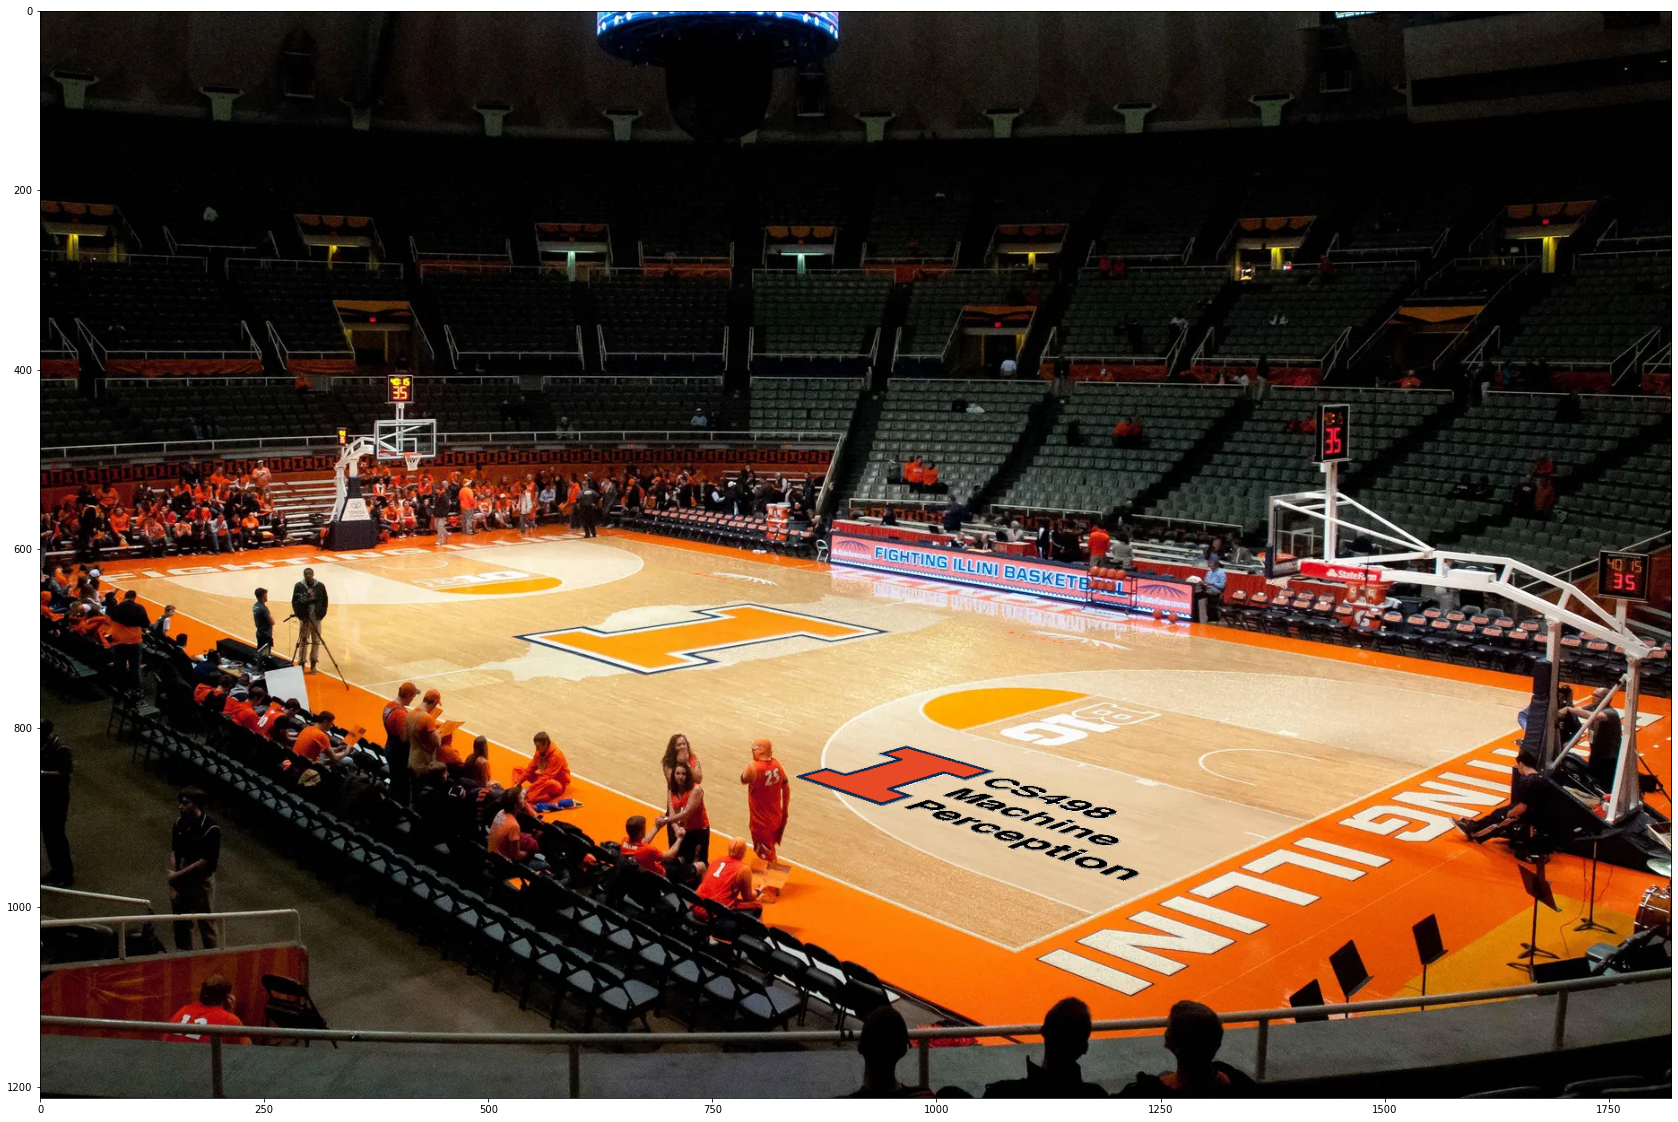

In [30]:
# Read the banner image that we want to insert to the basketball court
logo = imread('logo.png') / 255.0
banner_coor = np.array([[0,500], [1000,500], [1000,0], [0,0]])
box_coor = np.array([[23,5], [29,5], [29,2], [23,2]])
png_2_box_coor_hom = findHomography(banner_coor, box_coor)
target_transform = H @ png_2_box_coor_hom
im_copy = im.copy() # Create a copy of im image 

for x in range(logo.shape[1]):
    for y in range(logo.shape[0]):
        im_point = logo[y, x, :]  # Get point on image
        y = logo.shape[0] - y # Makes sure our y axis is the correct direction
        if im_point[-1] != 0:
            pass
        if not np.all((im_point == 0)):  # If all 0 in our RGBalpha point, ignore
            homography_point = target_transform.dot(np.array([x,y,1])) # Calculate homography mapping
            homography_point = (homography_point / homography_point[-1]).astype(np.int32)
            im_copy[homography_point[1], homography_point[0], :] = im_point
            
plt.figure(figsize=(30,20))            
plt.imshow(im_copy)
plt.show()

**Question 3b:**

omplete the warpImage function and use the homography you computed in 3.a to warp the image from its image coordinate to the image coordinate.

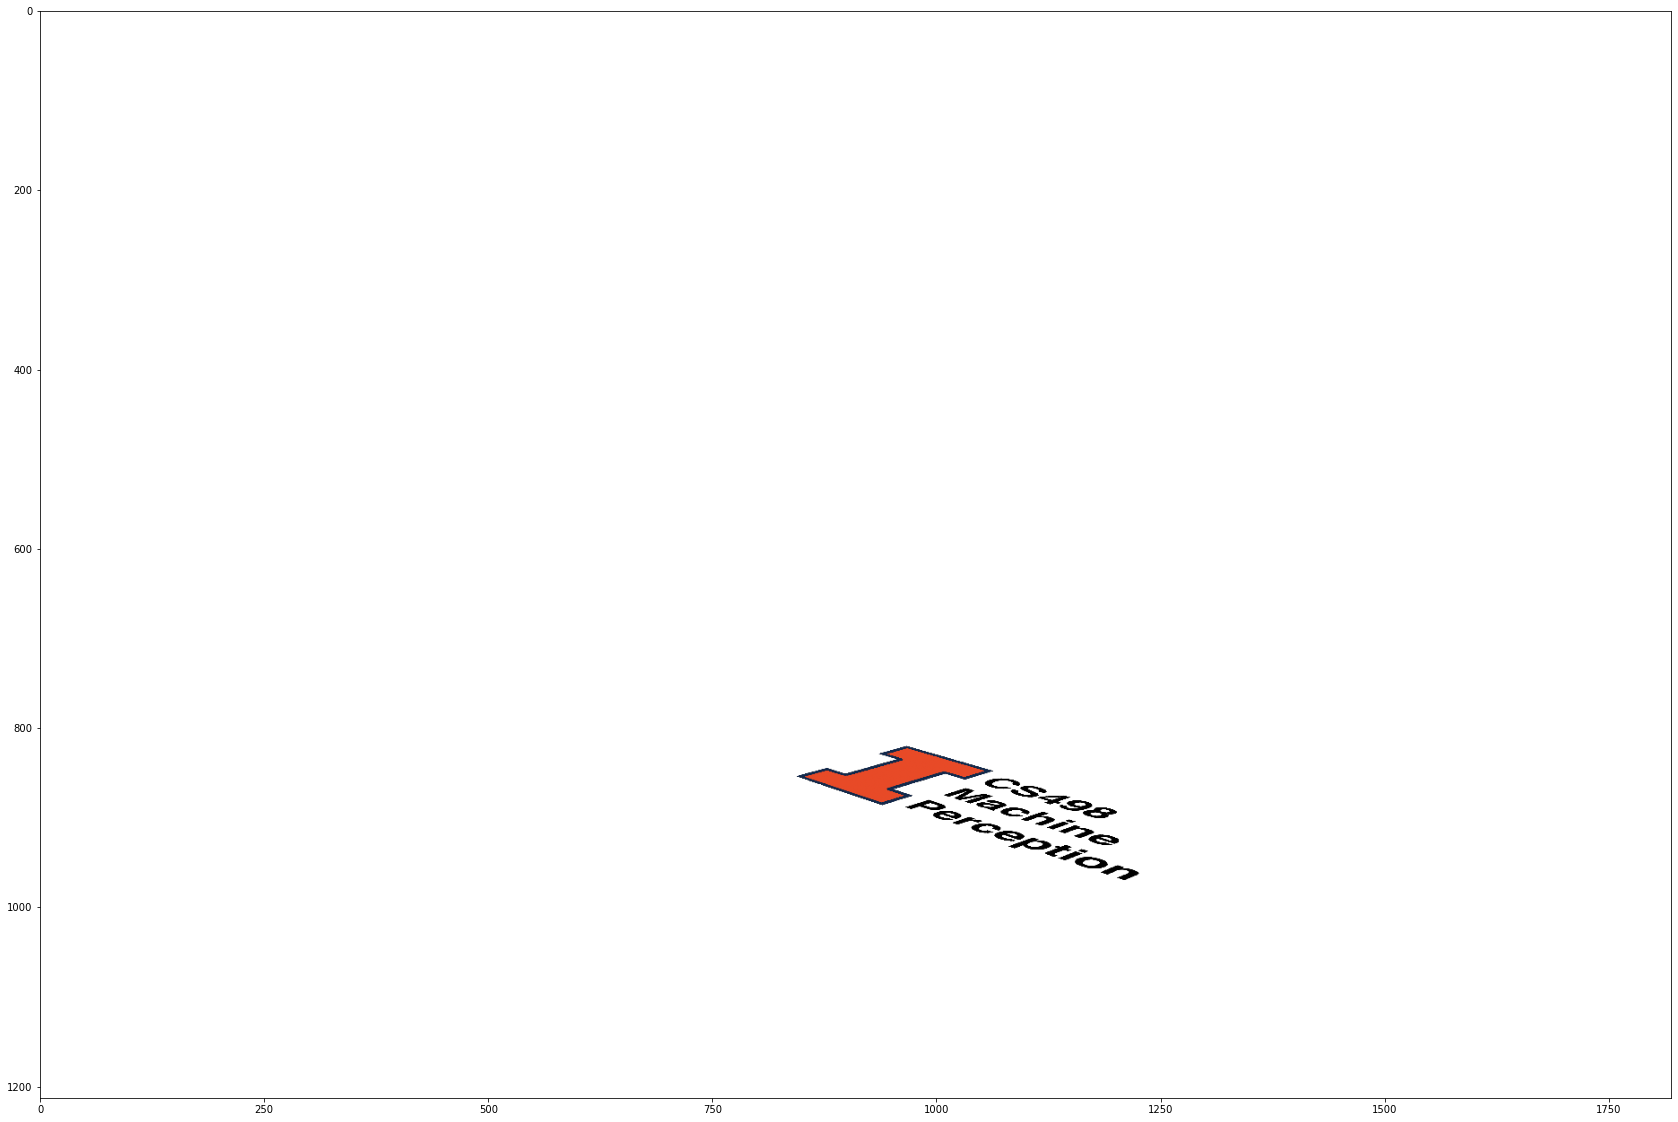

In [29]:
def warpImage(image, H, shape):
    x = np.arange(image.shape[1])
    y = np.arange(image.shape[0])
    xs, ys = np.meshgrid(x, y)

    im = np.zeros(shape=(shape[1], shape[0], 4))

    coordinates = np.stack((xs, ys), axis=-1).reshape(len(x) * len(y), 2)
    homo_coordinates = np.hstack((coordinates, np.ones(shape=(len(coordinates), 1)))).T
    
    # Flip y coordinate so we are in the correct orientation
    homo_coordinates[1, :] = image.shape[0] - homo_coordinates[1, :] 
    transformed_coordinates = H.dot(homo_coordinates).T
    transformed_coordinates[:, 0] = transformed_coordinates[:, 0] / transformed_coordinates[:, 2]
    transformed_coordinates[:, 1] = transformed_coordinates[:, 1] / transformed_coordinates[:, 2]
    transformed_coordinates[:, 2] = transformed_coordinates[:, 2] / transformed_coordinates[:, 2]

    transformed_coordinates = transformed_coordinates[:, 0:2].astype(np.int32)
    x_tr, y_tr = transformed_coordinates[:, 0], transformed_coordinates[:, 1]
    x_orig, y_orig = coordinates[:, 0], coordinates[:, 1]
    im[(y_tr, x_tr)] = image[(y_orig, x_orig)]

    return im

# call the warpImage function
logo_warp = warpImage(logo, target_transform, (im.shape[1], im.shape[0]))
            
plt.figure(figsize=(30,20))            
plt.imshow(logo_warp)
plt.show()


**Question 3c:**

alpha-blend the warped logo onto the court

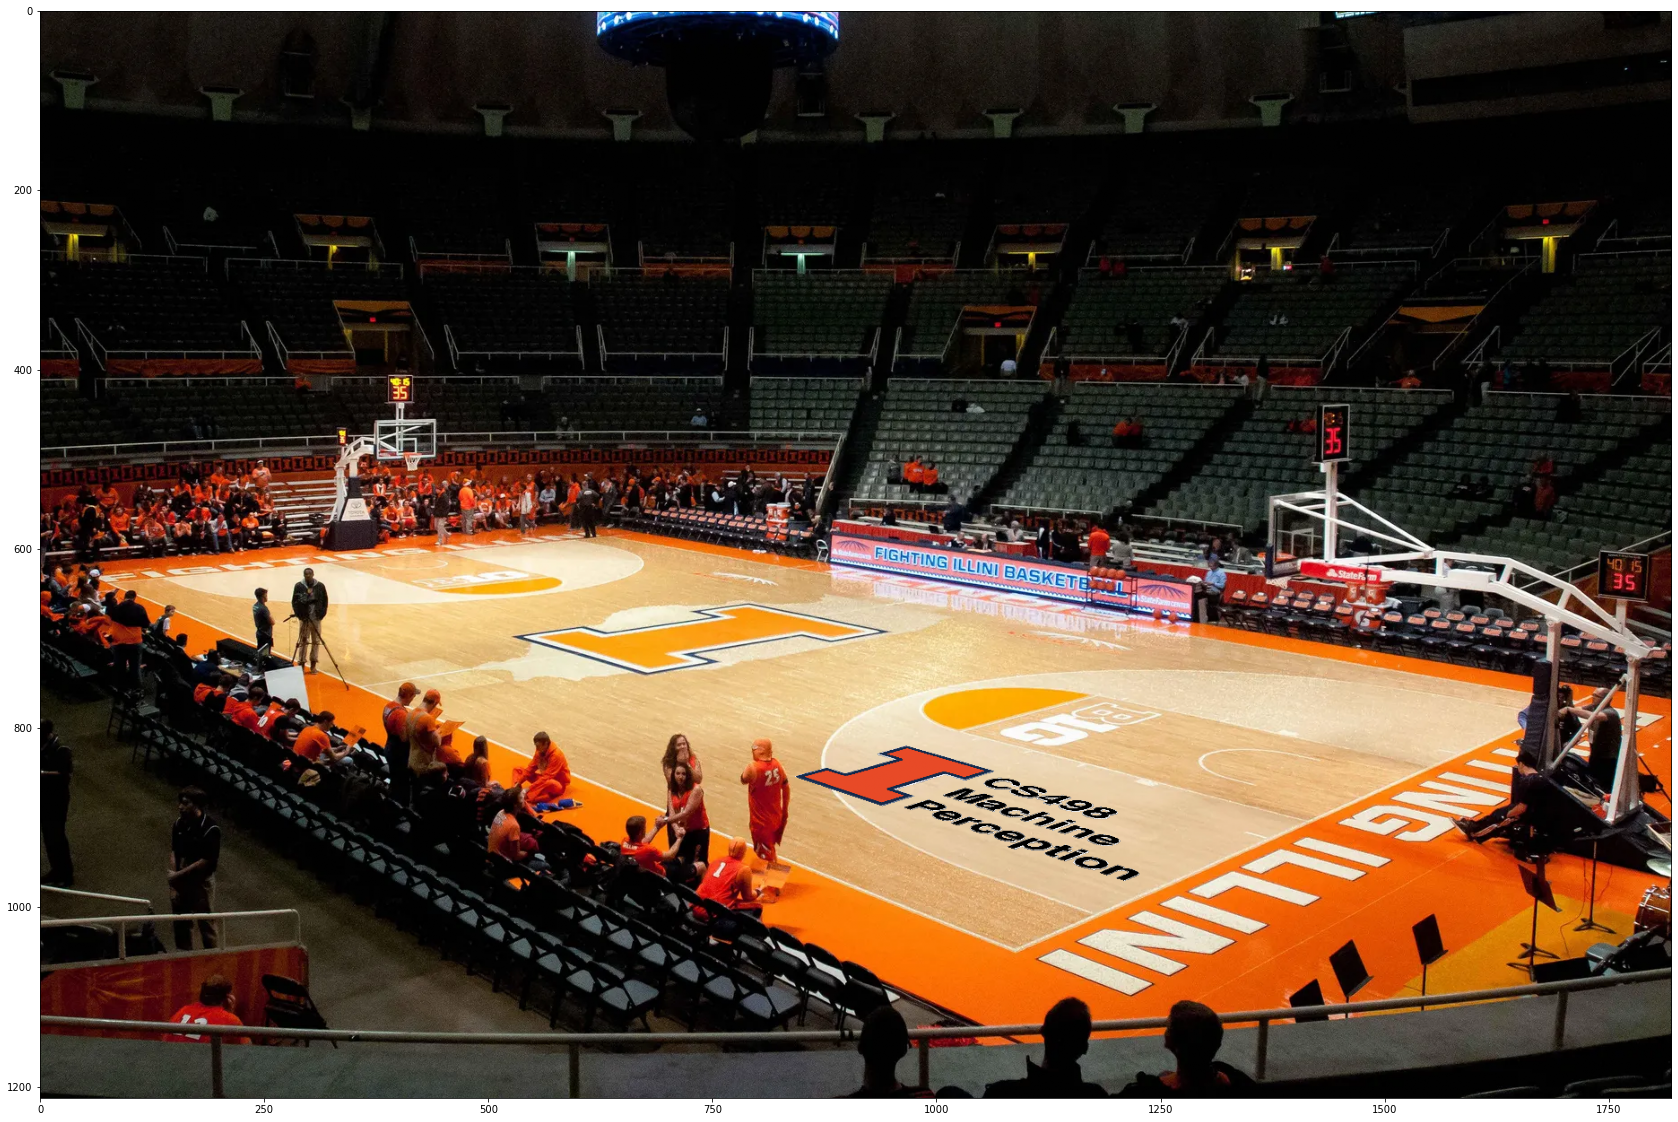

In [27]:
target_alpha = (im * (1 - logo_warp[:, :, 3])[:,:,None])
logo_alpha = (logo_warp * logo_warp[:, :, 3][:,:,None])
im = logo_alpha + target_alpha

plt.figure(figsize=(30,20))            
plt.imshow(im)
plt.show()

In [31]:
outfile = 'solution_homography.npz'
np.savez(outfile, corners_court, H, target_transform, logo_warp, im)

## Perspective

Till now we have been working on transformations between 2D coordinate systems. Now let us to lift up to the 3D coordinate. Consider the same image of the state farm center, but this time, we annotate four additional points, corresponding to the four corners of the basketball backboard. 